## Analizador Bioimagenes C. elegans - Conteo diferencia de nucleos fluorescentes

#### Cargar Imagenes

Entorno en PC:

readlink -f $(which java)

nano ~/.bashrc  # For bash users
# OR
nano ~/.zshrc   # For zsh users

export JAVA_HOME=/usr/lib/jvm/java-21-openjdk-amd64
export PATH=$JAVA_HOME/bin:$PATH

source ~/.bashrc

pip install python-bioformats

In [1]:
import numpy as np  
import pandas as pd 

In [2]:
from bioio import BioImage
import bioio_bioformats

In [28]:
ruta_base = "/home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/"
ruta_prueba_1 = ruta_base + "ztf30 1.ids"
img = BioImage(ruta_prueba_1, reader=bioio_bioformats.Reader)
print(type(img))

15:50:44.526 [main] INFO loci.formats.ImageReader - ICSReader initializing /home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids
15:50:44.526 [main] DEBUG loci.formats.FormatHandler - ICSReader initializing /home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids
15:50:44.526 [main] DEBUG loci.formats.FormatHandler - loci.formats.in.ICSReader.initFile(/home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids)
15:50:44.526 [main] INFO loci.formats.FormatHandler - Finding companion file
15:50:44.526 [main] INFO loci.formats.FormatHandler - Checking file version
15:50:44.529 [main] INFO loci.formats.FormatHandler - Reading metadata
15:50:44.583 [main] DEBUG loci.formats.FormatHandler - Could not parse double value 'Confocal C1 Scanner'
java.lang.NumberFormatException: For input string: "Confocal C1 Scanner"
	at java.base/jdk.internal.math.FloatingDecimal.readJavaFormatString(Unknown Source)
	at java.base

In [29]:
arr = img.data.squeeze()  # quita las dimensiones de tamaño 1
print(arr.shape)          # ahora debería ser (4, 1024, 1024)

# Acceso a un canal específico
canal_fluo = arr[1]  # Canal 1, etc.
canal_campo_claro = arr[3]

print(canal_fluo.shape, canal_fluo.dtype)
print(canal_campo_claro.shape, canal_campo_claro.dtype)

15:50:48.844 [main] INFO loci.formats.ImageReader - ICSReader initializing /home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids
15:50:48.845 [main] DEBUG loci.formats.FormatHandler - ICSReader initializing /home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids
15:50:48.845 [main] DEBUG loci.formats.FormatHandler - loci.formats.in.ICSReader.initFile(/home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids)
15:50:48.845 [main] INFO loci.formats.FormatHandler - Finding companion file
15:50:48.845 [main] INFO loci.formats.FormatHandler - Checking file version
15:50:48.846 [main] INFO loci.formats.FormatHandler - Reading metadata
15:50:48.865 [main] DEBUG loci.formats.FormatHandler - Could not parse double value 'Confocal C1 Scanner'
java.lang.NumberFormatException: For input string: "Confocal C1 Scanner"
	at java.base/jdk.internal.math.FloatingDecimal.readJavaFormatString(Unknown Source)
	at java.base

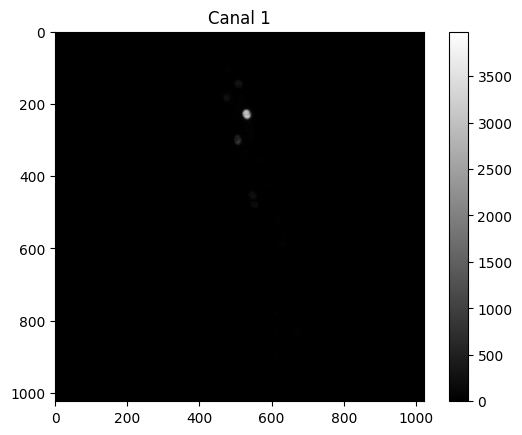

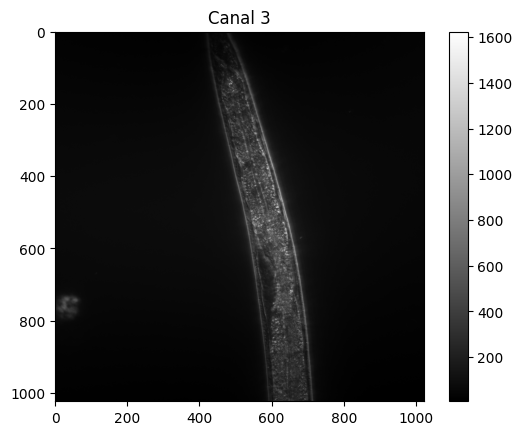

In [30]:
import matplotlib.pyplot as plt

def esImpar(i):
    return i%2 != 0

for i in range(arr.shape[0]):
    if (esImpar(i)):
        plt.figure()
        plt.imshow(arr[i], cmap="gray")
        plt.title(f"Canal {i}")
        plt.colorbar()
        plt.show()


In [31]:
# Normalizar las intensidades

fluo_norm = canal_fluo.astype(np.float32) / canal_fluo.max()

In [42]:
# Requisitos: numpy, scipy, scikit-image, matplotlib, pandas
import numpy as np
from scipy import ndimage as ndi
from skimage import exposure, filters, morphology, feature, segmentation, measure, util, color
import matplotlib.pyplot as plt
import pandas as pd

def detect_nuclei_large_diffuse(image, diameter_px=50,
                                 bg_sigma=50,
                                 clahe_kernel=64,
                                 clahe_clip=0.01,
                                 smooth_sigma=2,
                                 blob_min_sigma=None,
                                 blob_max_sigma=None,
                                 blob_thresh=0.02,
                                 percentile_mask=85,
                                 min_area_factor=0.5):
    """
    image: 2D numpy array (uint16 or float). Canal de fluorescencia.
    diameter_px: diámetro estimado de núcleos en pixeles (ej: 50).
    Devuelve: labels (2D int mask), dataframe con medidas, y algunas imágenes de diagnóstico.
    """
    # Parámetros derivados
    radius = diameter_px / 2.0
    if blob_min_sigma is None:
        # sigma_est ~ radius / sqrt(2); ponemos rango un poco amplio
        sigma_est = radius / np.sqrt(2)
        blob_min_sigma = max(6, sigma_est * 0.6)
    if blob_max_sigma is None:
        blob_max_sigma = max(blob_min_sigma + 2, sigma_est * 1.4)

    # 1) asegurarse float y normalizar (0..1)
    img = image.astype(np.float32)
    img -= img.min()
    if img.max() > 0:
        img /= img.max()

    # 2) fondo: gaussian blur (gran sigma) y resta → fondo local
    background = ndi.gaussian_filter(img, sigma=bg_sigma)
    img_bs = img - background
    img_bs = np.clip(img_bs, 0, None)
    if img_bs.max() > 0:
        img_bs /= img_bs.max()

    # 3) mejorar contraste (CLAHE)
    img_clahe = exposure.equalize_adapthist(img_bs, kernel_size=clahe_kernel, clip_limit=clahe_clip)

    # 4) suavizar para detección de semillas
    img_smooth = filters.gaussian(img_clahe, sigma=smooth_sigma)

    # 5) máscara inicial con umbral por percentil (más robusto que Otsu para difuso)
    thr = np.percentile(img_smooth, percentile_mask)
    mask = img_smooth > thr
    # eliminar pequeños residuos
    approx_area = np.pi * (radius**2)
    min_area = int(min_area_factor * approx_area)  # p.ej. 0.5 * area esperada
    mask = morphology.remove_small_objects(mask, min_size=max(50, min_area))

    # 6) distancia y detección de semillas con blob_log (LoG)
    distance = ndi.distance_transform_edt(mask)

    # blob_log expects the original intensity (or smooth), returns (y,x,sigma)
    blobs = feature.blob_log(img_smooth,
                             min_sigma=blob_min_sigma,
                             max_sigma=blob_max_sigma,
                             num_sigma=8,
                             threshold=blob_thresh)
    # crear marcadores a partir de blobs
    markers = np.zeros_like(image, dtype=np.int32)
    for i, (y, x, s) in enumerate(blobs, start=1):
        r = int(round(y)); c = int(round(x))
        if 0 <= r < markers.shape[0] and 0 <= c < markers.shape[1]:
            markers[r, c] = i

    # fallback: si no encontró seeds, usar peak_local_max sobre distance
    if markers.sum() == 0:
        coords = feature.peak_local_max(distance, min_distance=int(radius*0.5), threshold_rel=0.2)
        for i, (r, c) in enumerate(coords, start=1):
            markers[r, c] = i

    # 7) watershed marcado: separa núcleos pegados
    labels = segmentation.watershed(-distance, markers, mask=mask)

    # 8) limpieza: eliminar objetos muy chicos, rellenar huecos
    labels = morphology.remove_small_objects(labels, min_size=max(50, int(0.4 * approx_area)))
    # opcional: reasignar etiquetas contiguas
    labels = measure.label(labels)

    # 9) medidas por región
    props = measure.regionprops(labels, intensity_image=image)
    results = []
    for p in props:
        lab = p.label
        area = p.area
        mean_int = p.mean_intensity
        total_int = mean_int * area
        y0, x0 = p.centroid
        maj = p.major_axis_length
        minr = p.minor_axis_length
        results.append({
            "label": lab, "area": area, "centroid_y": y0, "centroid_x": x0,
            "major_axis": maj, "minor_axis": minr,
            "mean_intensity": mean_int, "total_intensity": total_int
        })
    df = pd.DataFrame(results)

    # diagnostic images for plotting
    overlay = color.label2rgb(labels, image=util.img_as_float(image), bg_label=0, alpha=0.35)

    return labels, df, {
        "img_smooth": img_smooth, "mask": mask, "distance": distance,
        "blobs": blobs, "overlay": overlay
    }

# Uso ejemplo:
# canal_fluo: tu canal 2D (ej: arr[1])
labels, df, diag = detect_nuclei_large_diffuse(canal_fluo, diameter_px=50)
print("Núcleos detectados:", len(df))
df.describe()

Núcleos detectados: 5


,label,area,centroid_y,centroid_x,major_axis,minor_axis,mean_intensity,total_intensity
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00
mean,3.000000,21658.800000,296.316339,519.406832,261.475994,81.293348,95.417137,6.140180e+05
std,1.581139,35229.045881,230.975599,55.716062,300.240793,36.190646,144.379330,5.638891e+05
min,1.000000,3841.000000,89.341622,470.324915,87.773780,49.741241,11.368483,1.236790e+05
25%,2.000000,4078.000000,169.928404,477.801966,108.879720,64.624972,19.034398,1.936750e+05
50%,3.000000,5686.000000,229.529181,517.180971,109.654197,72.791964,32.199688,3.595400e+05
75%,4.000000,10175.000000,309.220190,521.389652,209.185242,75.855445,63.232501,9.607960e+05
max,5.000000,84514.000000,683.562297,610.336654,791.887034,143.453117,351.250613,1.432400e+06


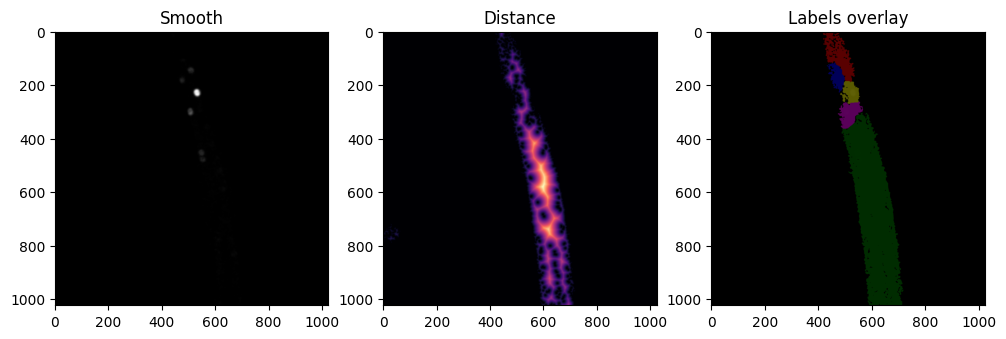

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(diag["img_smooth"], cmap="gray"); plt.title("Smooth")
plt.subplot(1,3,2); plt.imshow(diag["distance"], cmap="magma"); plt.title("Distance")
plt.subplot(1,3,3); plt.imshow(diag["overlay"]); plt.title("Labels overlay")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import exposure, filters, morphology, feature, segmentation, measure, util, color
from skimage.morphology import disk
from skimage.filters import threshold_otsu
from skimage.feature import peak_local_max
from skimage.morphology import h_maxima

def detect_nuclei_improved(image, diameter_px=50):
    """
    image: 2D numpy array (float or uint)
    diameter_px: diámetro estimado de núcleos (ej 50)
    """
    # Parámetros derivados
    radius = diameter_px / 2.0
    min_area = int(0.4 * np.pi * radius**2)   # filtro post
    # 1) normalizar
    img = image.astype(np.float32)
    img -= img.min()
    if img.max() > 0:
        img /= img.max()

    # 2) background subtraction (rolling ball simplificado con gaussian grande)
    bg = ndi.gaussian_filter(img, sigma=radius*1.2)   # sigma grande
    img_bs = img - bg
    img_bs = np.clip(img_bs, 0, None)
    if img_bs.max() > 0:
        img_bs /= img_bs.max()

    # 3) realzar objetos redondeados: white_tophat con struct element cercano al radio
    selem_tophat = disk(int(max(5, radius*0.6)))
    img_tophat = morphology.white_tophat(img_bs, footprint=selem_tophat)

    # 4) mejorar contraste localmente (CLAHE)
    img_clahe = exposure.equalize_adapthist(img_tophat, kernel_size=64, clip_limit=0.01)

    # 5) suavizar
    img_smooth = filters.gaussian(img_clahe, sigma=2)

    # 6) máscara inicial con percentil alto para evitar filamentos
    thr = np.percentile(img_smooth, 90)   # sube si hay mucho fondo (ajustar 80-95)
    mask = img_smooth > thr
    # morfología: cerrar para llenar huecos y abrir para eliminar ramitas
    mask = morphology.binary_closing(mask, selem=disk(int(radius*0.2)))
    mask = morphology.binary_opening(mask, selem=disk(int(radius*0.25)))
    mask = morphology.remove_small_objects(mask, min_size=max(50, int(0.2 * np.pi * radius**2)))

    # 7) distance transform
    distance = ndi.distance_transform_edt(mask)

    # 8) Semillas robustas: usar h_maxima para suprimir picos pequeños
    # h como fracción del max distance; prueba entre 0.15-0.4
    h = max(3, 0.25 * np.max(distance))   # ajustar si detecta demasiado/menos
    maxima_mask = h_maxima(distance, h=h)
    markers = ndi.label(maxima_mask)[0]

    # Fallback: si no hubo markers suficientes, usar peak_local_max con min_distance
    if markers.max() < 2:
        coords = peak_local_max(distance, min_distance=int(radius*0.6),
                                threshold_rel=0.2)
        markers = np.zeros_like(distance, dtype=int)
        for i, (r, c) in enumerate(coords, start=1):
            markers[r, c] = i

    # 9) watershed marcado (neg distance para que cúspides sean pozos)
    labels = segmentation.watershed(-distance, markers, mask=mask)

    # 10) limpieza de labels: eliminar muy pequeños y reasignar índices
    labels = morphology.remove_small_objects(labels, min_size=min_area)
    labels = measure.label(labels)   # compact labels

    # 11) medidas
    props = measure.regionprops(labels, intensity_image=image)
    results = []
    for p in props:
        results.append({
            "label": p.label,
            "area": p.area,
            "centroid_y": p.centroid[0],
            "centroid_x": p.centroid[1],
            "mean_intensity": p.mean_intensity,
            "total_intensity": p.mean_intensity * p.area
        })

    return labels, np.array(results), {"img_smooth": img_smooth, "mask": mask, "distance": distance, "maxima_mask": maxima_mask}

# ---- USO ----
labels, arr_props, diag = detect_nuclei_improved(canal_fluo, diameter_px=50)
print("Detected:", labels.max())
# Mostrar overlay + semillas
def plot_diagnostics(image, labels, diag):
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(diag["img_smooth"], cmap="gray"); plt.title("Smooth")
    plt.subplot(1,4,2); plt.imshow(diag["distance"], cmap="magma"); plt.title("Distance")
    plt.subplot(1,4,3); plt.imshow(diag["maxima_mask"], cmap="gray"); plt.title("Maxima (h_maxima)")
    plt.subplot(1,4,4); plt.imshow(color.label2rgb(labels, image=util.img_as_float(image), bg_label=0, alpha=0.35))
    plt.title("Labels overlay")
    plt.show()

plot_diagnostics(canal_fluo, labels, diag)

TypeError: white_tophat() got an unexpected keyword argument 'selem'

In [33]:
intensidades = [np.sum(canal_fluo[region.coords[:,0], region.coords[:,1]])
                for region in regionprops(labels)]
print("Promedio:", np.mean(intensidades))
print("Desviación:", np.std(intensidades))

Promedio: 372963.0
Desviación: 525550.0496533767
